<a href="https://colab.research.google.com/github/amitav710/SAiDl/blob/main/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning

Importing the Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import argparse

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import regularizers

import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import math
from tensorflow.keras import layers
from tensorflow.keras.layers import (
 Conv2D,
 BatchNormalization,
 Dense,
 MaxPool2D,
 Flatten,
 Dropout,
 Add,
 ReLU
)

Loading and formatting datasets

In [2]:
ds_train, info_train = tfds.load('stl10', split='train', with_info=True, shuffle_files=True, as_supervised=True)
df_train = tfds.as_dataframe(ds_train.take(5), info_train)
df_train.head()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteF7GK2X/stl10-train.tfrecord


  0%|          | 0/5000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteF7GK2X/stl10-test.tfrecord


  0%|          | 0/8000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stl10/1.0.0.incompleteF7GK2X/stl10-unlabelled.tfrecord


  0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset stl10 downloaded and prepared to /root/tensorflow_datasets/stl10/1.0.0. Subsequent calls will reuse this data.


,image,label
0,"[[[136, 144, 153], [125, 127, 136], [125, 126,...",1
1,"[[[70, 132, 186], [81, 139, 189], [143, 176, 2...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",8
3,"[[[104, 90, 69], [101, 87, 66], [103, 88, 67],...",3
4,"[[[189, 204, 235], [189, 204, 235], [189, 204,...",9


In [3]:
ds_test, info_test = tfds.load('stl10', split='test', with_info=True, shuffle_files=True, as_supervised=True)
df_test = tfds.as_dataframe(ds_test.take(5), info_test)
df_test.head()

,image,label
0,"[[[213, 214, 220], [219, 219, 225], [220, 221,...",9
1,"[[[31, 36, 32], [37, 42, 42], [60, 63, 60], [5...",3
2,"[[[87, 87, 74], [84, 86, 76], [80, 82, 75], [8...",3
3,"[[[37, 76, 22], [40, 79, 22], [43, 76, 25], [4...",1
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",9


In [49]:
x_train=[]
y_train=[]
for data in ds_train:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_train.append(x)
  y_train.append(y)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train.shape

(5000, 96, 96, 3)

In [50]:
y_train = pd.get_dummies(y_train)
y_train.shape

(5000, 10)

In [51]:
x_test=[]
y_test=[]

for data in ds_test:
  x,y = data
  x=x.numpy()
  y=y.numpy()
  x_test.append(x)
  y_test.append(y)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_test = pd.get_dummies(y_test)

In [52]:
x_test.shape

(8000, 96, 96, 3)

In [53]:
y_test.shape

(8000, 10)

Image augmentation

In [54]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

In [55]:
training_set = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

In [56]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=test_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

Making the CNN

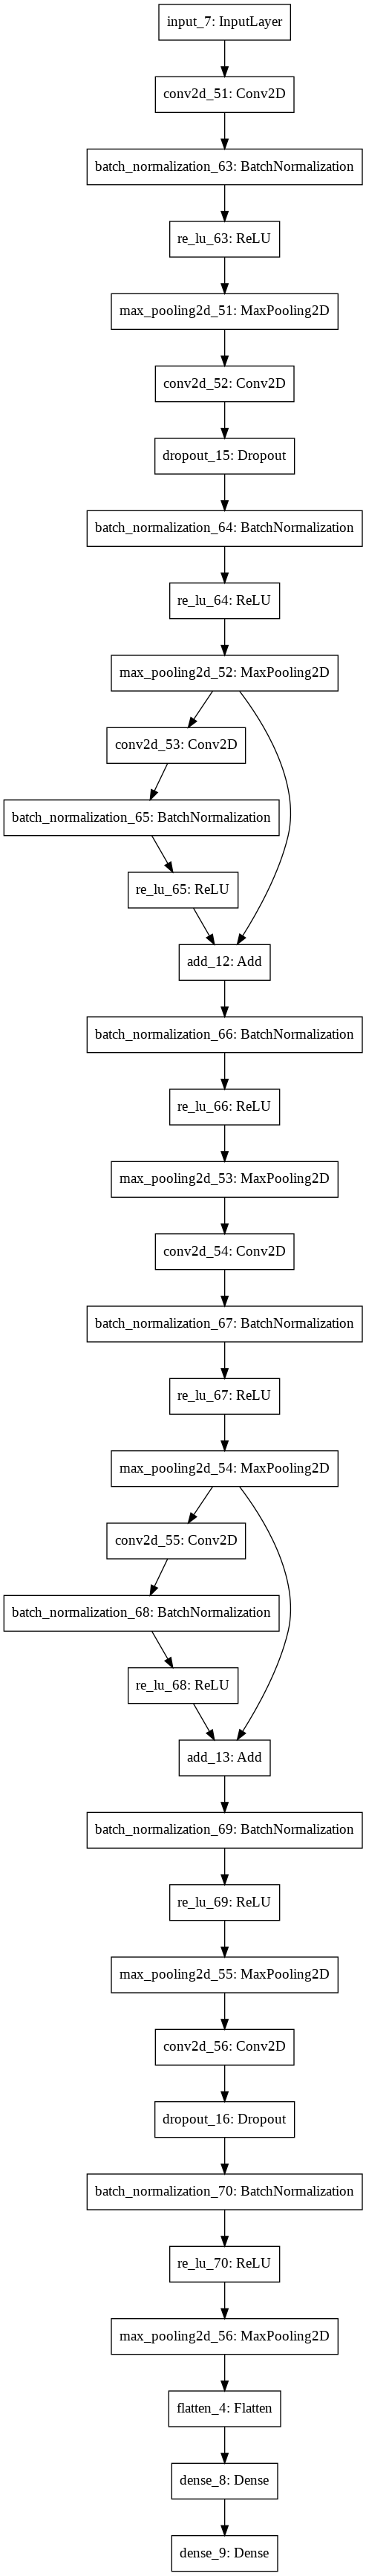

In [57]:
shape=(96,96,3)
input=layers.Input(shape)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(96, (3, 3), strides=1,padding="same"))(input)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x=(Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy1=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy2=x
x = Add()([x_copy1,x_copy2])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1,padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

#residual layer
x_copy3=x
x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x_copy4=x
x = Add()([x_copy3,x_copy4])
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)

x = (Conv2D(64, (3, 3), strides=1, activation="relu",bias_regularizer=regularizers.l1(0.00005),padding="same"))(x)
x = (Dropout(0.2))(x)
x = (BatchNormalization(epsilon=1e-5, momentum=0.01))(x)
x = (ReLU())(x)
x = (MaxPool2D((2, 2), strides=2))(x)
x = (Flatten())(x)
x = (Dense(128, activation = 'relu'))(x)
output = (Dense(units=10,activation = 'softmax'))(x)

cnn = tf.keras.Model(inputs=input, outputs=output)
plot_model(cnn)

In [60]:
stop = EarlyStopping(patience=25, monitor='val_loss', mode='min')

In [59]:
"""initial_learning_rate = 0.01
decay_steps = 10.0
decay_rate = 0.75
learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate, 
  decay_steps, 
  decay_rate,
  staircase=True
)"""

'initial_learning_rate = 0.01\ndecay_steps = 10.0\ndecay_rate = 0.75\nlearning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(\n  initial_learning_rate, \n  decay_steps, \n  decay_rate,\n  staircase=True\n)'

Training the CNN

In [62]:
opt=tf.keras.optimizers.Adam(learning_rate=0.0004)

In [63]:
cnn.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
model_checkpoint_callback = ModelCheckpoint('checkpoint', save_best_only=True, monitor='val_accuracy', mode='max')

In [65]:
cnn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 96, 96, 96)   2688        input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 96, 96, 96)   384         conv2d_51[0][0]                  
__________________________________________________________________________________________________
re_lu_63 (ReLU)                 (None, 96, 96, 96)   0           batch_normalization_63[0][0]     
____________________________________________________________________________________________

In [66]:
history=cnn.fit(x=training_set, validation_data=test_set, epochs= 120, batch_size=32, callbacks=[stop, model_checkpoint_callback])

Epoch 1/120
157/157 [==============================] - 16s 96ms/step - loss: 2.0332 - accuracy: 0.2556 - val_loss: 1.7553 - val_accuracy: 0.3232
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 2/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 1.7028 - accuracy: 0.3468 - val_loss: 1.6595 - val_accuracy: 0.3778
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 3/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 90ms/step - loss: 1.5780 - accuracy: 0.3992 - val_loss: 1.5091 - val_accuracy: 0.4277
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 4/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 90ms/step - loss: 1.5026 - accuracy: 0.4310 - val_loss: 1.4745 - val_accuracy: 0.4610
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 5/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 90ms/step - loss: 1.4375 - accuracy: 0.4584 - val_loss: 1.4044 - val_accuracy: 0.4746
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 6/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 90ms/step - loss: 1.3747 - accuracy: 0.4830 - val_loss: 1.2842 - val_accuracy: 0.5232
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 7/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 1.3193 - accuracy: 0.5076 - val_loss: 1.2774 - val_accuracy: 0.5171
Epoch 8/120
157/157 [==============================] - 14s 89ms/step - loss: 1.2767 - accuracy: 0.5126 - val_loss: 1.2051 - val_accuracy: 0.5584
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 9/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 1.2397 - accuracy: 0.5304 - val_loss: 1.2742 - val_accuracy: 0.5120
Epoch 10/120
157/157 [==============================] - 14s 91ms/step - loss: 1.2027 - accuracy: 0.5490 - val_loss: 1.2607 - val_accuracy: 0.5257
Epoch 11/120
157/157 [==============================] - 14s 91ms/step - loss: 1.1421 - accuracy: 0.5722 - val_loss: 1.2809 - val_accuracy: 0.5174
Epoch 12/120
157/157 [==============================] - 14s 91ms/step - loss: 1.1432 - accuracy: 0.5726 - val_loss: 1.1088 - val_accuracy: 0.5960
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 13/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 1.0907 - accuracy: 0.5984 - val_loss: 1.1909 - val_accuracy: 0.5679
Epoch 14/120
157/157 [==============================] - 14s 91ms/step - loss: 1.0806 - accuracy: 0.6006 - val_loss: 1.1284 - val_accuracy: 0.5822
Epoch 15/120
157/157 [==============================] - 14s 92ms/step - loss: 1.0406 - accuracy: 0.6124 - val_loss: 1.0353 - val_accuracy: 0.6231
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 16/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 1.0186 - accuracy: 0.6244 - val_loss: 1.0862 - val_accuracy: 0.5985
Epoch 17/120
157/157 [==============================] - 14s 91ms/step - loss: 1.0065 - accuracy: 0.6242 - val_loss: 1.0394 - val_accuracy: 0.6130
Epoch 18/120
157/157 [==============================] - 14s 90ms/step - loss: 0.9812 - accuracy: 0.6332 - val_loss: 1.0793 - val_accuracy: 0.6049
Epoch 19/120
157/157 [==============================] - 14s 91ms/step - loss: 0.9600 - accuracy: 0.6406 - val_loss: 1.0139 - val_accuracy: 0.6259
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 20/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 0.9406 - accuracy: 0.6584 - val_loss: 1.0622 - val_accuracy: 0.6161
Epoch 21/120
157/157 [==============================] - 14s 91ms/step - loss: 0.9426 - accuracy: 0.6526 - val_loss: 1.0541 - val_accuracy: 0.6137
Epoch 22/120
157/157 [==============================] - 14s 90ms/step - loss: 0.9567 - accuracy: 0.6504 - val_loss: 0.9931 - val_accuracy: 0.6403
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 23/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 91ms/step - loss: 0.9080 - accuracy: 0.6656 - val_loss: 1.0118 - val_accuracy: 0.6309
Epoch 24/120
157/157 [==============================] - 14s 89ms/step - loss: 0.9050 - accuracy: 0.6742 - val_loss: 0.9334 - val_accuracy: 0.6669
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 25/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 15s 95ms/step - loss: 0.8653 - accuracy: 0.6862 - val_loss: 1.0020 - val_accuracy: 0.6352
Epoch 26/120
157/157 [==============================] - 15s 95ms/step - loss: 0.8577 - accuracy: 0.6926 - val_loss: 1.0123 - val_accuracy: 0.6398
Epoch 27/120
157/157 [==============================] - 15s 95ms/step - loss: 0.8640 - accuracy: 0.6766 - val_loss: 0.9739 - val_accuracy: 0.6421
Epoch 28/120
157/157 [==============================] - 15s 96ms/step - loss: 0.8532 - accuracy: 0.6816 - val_loss: 0.9339 - val_accuracy: 0.6686
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 29/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 15s 96ms/step - loss: 0.8182 - accuracy: 0.7030 - val_loss: 0.9204 - val_accuracy: 0.6686
Epoch 30/120
157/157 [==============================] - 15s 95ms/step - loss: 0.8331 - accuracy: 0.6990 - val_loss: 1.0282 - val_accuracy: 0.6428
Epoch 31/120
157/157 [==============================] - 15s 95ms/step - loss: 0.8010 - accuracy: 0.7074 - val_loss: 0.9187 - val_accuracy: 0.6671
Epoch 32/120
157/157 [==============================] - 15s 96ms/step - loss: 0.8039 - accuracy: 0.7028 - val_loss: 0.9073 - val_accuracy: 0.6764
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 33/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 15s 95ms/step - loss: 0.7863 - accuracy: 0.7202 - val_loss: 0.9662 - val_accuracy: 0.6515
Epoch 34/120
157/157 [==============================] - 15s 94ms/step - loss: 0.7803 - accuracy: 0.7164 - val_loss: 0.8749 - val_accuracy: 0.6870
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 35/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 15s 93ms/step - loss: 0.7668 - accuracy: 0.7186 - val_loss: 0.8777 - val_accuracy: 0.6883
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 36/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 15s 93ms/step - loss: 0.7311 - accuracy: 0.7328 - val_loss: 0.9282 - val_accuracy: 0.6726
Epoch 37/120
157/157 [==============================] - 15s 95ms/step - loss: 0.7376 - accuracy: 0.7324 - val_loss: 0.8967 - val_accuracy: 0.6815
Epoch 38/120
157/157 [==============================] - 15s 94ms/step - loss: 0.7386 - accuracy: 0.7336 - val_loss: 0.9282 - val_accuracy: 0.6720
Epoch 39/120
157/157 [==============================] - 15s 95ms/step - loss: 0.7188 - accuracy: 0.7362 - val_loss: 0.9713 - val_accuracy: 0.6630
Epoch 40/120
157/157 [==============================] - 15s 94ms/step - loss: 0.7139 - accuracy: 0.7420 - val_loss: 0.9500 - val_accuracy: 0.6674
Epoch 41/120
157/157 [==============================] - 15s 94ms/step - loss: 0.7116 - accuracy: 0.7422 - val_loss: 0.8879 - val_accuracy: 0.6824
Epoch 42/120
157/157 [==============================] - 15s 95ms/step - loss: 0.6635 - accuracy: 0.7660 - val_loss: 0.9809 - val_accuracy

INFO:tensorflow:Assets written to: checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 47/120
157/157 [==============================] - 14s 90ms/step - loss: 0.6444 - accuracy: 0.7684 - val_loss: 0.8724 - val_accuracy: 0.6951
Epoch 48/120
157/157 [==============================] - 14s 90ms/step - loss: 0.6531 - accuracy: 0.7642 - val_loss: 0.8491 - val_accuracy: 0.7091
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 49/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 89ms/step - loss: 0.6472 - accuracy: 0.7628 - val_loss: 0.8986 - val_accuracy: 0.6873
Epoch 50/120
157/157 [==============================] - 14s 91ms/step - loss: 0.6459 - accuracy: 0.7666 - val_loss: 0.8578 - val_accuracy: 0.7016
Epoch 51/120
157/157 [==============================] - 14s 89ms/step - loss: 0.6002 - accuracy: 0.7876 - val_loss: 0.8558 - val_accuracy: 0.6986
Epoch 52/120
157/157 [==============================] - 14s 90ms/step - loss: 0.6163 - accuracy: 0.7750 - val_loss: 0.9558 - val_accuracy: 0.6676
Epoch 53/120
157/157 [==============================] - 14s 90ms/step - loss: 0.6090 - accuracy: 0.7820 - val_loss: 0.8710 - val_accuracy: 0.6900
Epoch 54/120
157/157 [==============================] - 14s 89ms/step - loss: 0.6064 - accuracy: 0.7810 - val_loss: 0.8782 - val_accuracy: 0.6960
Epoch 55/120
157/157 [==============================] - 14s 90ms/step - loss: 0.6004 - accuracy: 0.7842 - val_loss: 0.8157 - val_accuracy

INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 56/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 90ms/step - loss: 0.6086 - accuracy: 0.7762 - val_loss: 0.8615 - val_accuracy: 0.7019
Epoch 57/120
157/157 [==============================] - 14s 90ms/step - loss: 0.5672 - accuracy: 0.7980 - val_loss: 0.8487 - val_accuracy: 0.7028
Epoch 58/120
157/157 [==============================] - 14s 89ms/step - loss: 0.5723 - accuracy: 0.7974 - val_loss: 0.7999 - val_accuracy: 0.7220
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 59/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 89ms/step - loss: 0.5798 - accuracy: 0.7936 - val_loss: 0.8459 - val_accuracy: 0.7069
Epoch 60/120
157/157 [==============================] - 14s 90ms/step - loss: 0.5492 - accuracy: 0.7958 - val_loss: 0.8385 - val_accuracy: 0.7097
Epoch 61/120
157/157 [==============================] - 14s 90ms/step - loss: 0.5535 - accuracy: 0.7938 - val_loss: 0.8337 - val_accuracy: 0.7145
Epoch 62/120
157/157 [==============================] - 14s 91ms/step - loss: 0.5536 - accuracy: 0.7976 - val_loss: 0.8157 - val_accuracy: 0.7195
Epoch 63/120
157/157 [==============================] - 14s 90ms/step - loss: 0.5539 - accuracy: 0.7948 - val_loss: 0.8906 - val_accuracy: 0.6981
Epoch 64/120
157/157 [==============================] - 14s 89ms/step - loss: 0.5363 - accuracy: 0.8046 - val_loss: 0.8633 - val_accuracy: 0.7028
Epoch 65/120
157/157 [==============================] - 14s 88ms/step - loss: 0.5391 - accuracy: 0.8094 - val_loss: 0.8602 - val_accuracy

INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 70/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 89ms/step - loss: 0.5076 - accuracy: 0.8170 - val_loss: 0.8420 - val_accuracy: 0.7219
Epoch 71/120
157/157 [==============================] - 14s 88ms/step - loss: 0.5293 - accuracy: 0.8116 - val_loss: 0.8415 - val_accuracy: 0.7166
Epoch 72/120
157/157 [==============================] - 14s 90ms/step - loss: 0.5209 - accuracy: 0.8150 - val_loss: 0.8176 - val_accuracy: 0.7224
Epoch 73/120
157/157 [==============================] - 14s 90ms/step - loss: 0.5009 - accuracy: 0.8220 - val_loss: 0.7825 - val_accuracy: 0.7343
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 74/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 89ms/step - loss: 0.4990 - accuracy: 0.8244 - val_loss: 0.8996 - val_accuracy: 0.6973
Epoch 75/120
157/157 [==============================] - 14s 88ms/step - loss: 0.4893 - accuracy: 0.8252 - val_loss: 0.8708 - val_accuracy: 0.7095
Epoch 76/120
157/157 [==============================] - 14s 88ms/step - loss: 0.4933 - accuracy: 0.8192 - val_loss: 0.8484 - val_accuracy: 0.7191
Epoch 77/120
157/157 [==============================] - 14s 88ms/step - loss: 0.4909 - accuracy: 0.8250 - val_loss: 0.8738 - val_accuracy: 0.7082
Epoch 78/120
157/157 [==============================] - 14s 88ms/step - loss: 0.4821 - accuracy: 0.8232 - val_loss: 0.9262 - val_accuracy: 0.6952
Epoch 79/120
157/157 [==============================] - 14s 88ms/step - loss: 0.4696 - accuracy: 0.8312 - val_loss: 0.8599 - val_accuracy: 0.7164
Epoch 80/120
157/157 [==============================] - 14s 87ms/step - loss: 0.4808 - accuracy: 0.8226 - val_loss: 0.9057 - val_accuracy

INFO:tensorflow:Assets written to: checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 90/120
157/157 [==============================] - 14s 91ms/step - loss: 0.4214 - accuracy: 0.8508 - val_loss: 0.8574 - val_accuracy: 0.7154
Epoch 91/120
157/157 [==============================] - 14s 90ms/step - loss: 0.4341 - accuracy: 0.8438 - val_loss: 0.8908 - val_accuracy: 0.7069
Epoch 92/120
157/157 [==============================] - 14s 90ms/step - loss: 0.4405 - accuracy: 0.8472 - val_loss: 0.7825 - val_accuracy: 0.7406
INFO:tensorflow:Assets written to: checkpoint/assets


INFO:tensorflow:Assets written to: checkpoint/assets


Epoch 93/120


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


157/157 [==============================] - 14s 90ms/step - loss: 0.4037 - accuracy: 0.8552 - val_loss: 0.8823 - val_accuracy: 0.7188
Epoch 94/120
157/157 [==============================] - 14s 89ms/step - loss: 0.4110 - accuracy: 0.8534 - val_loss: 0.8452 - val_accuracy: 0.7286
Epoch 95/120
157/157 [==============================] - 14s 90ms/step - loss: 0.4116 - accuracy: 0.8496 - val_loss: 0.9676 - val_accuracy: 0.6982
Epoch 96/120
157/157 [==============================] - 14s 88ms/step - loss: 0.4027 - accuracy: 0.8550 - val_loss: 0.9170 - val_accuracy: 0.7185
Epoch 97/120
157/157 [==============================] - 14s 89ms/step - loss: 0.4123 - accuracy: 0.8512 - val_loss: 0.8245 - val_accuracy: 0.7291
Epoch 98/120
157/157 [==============================] - 14s 89ms/step - loss: 0.4204 - accuracy: 0.8516 - val_loss: 0.8248 - val_accuracy: 0.7287


Accuracy History

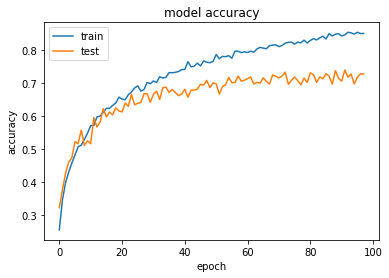

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss History

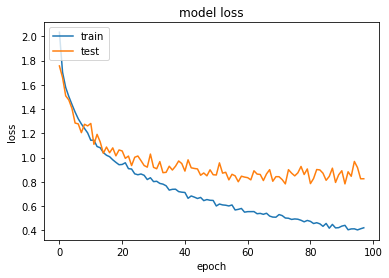

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
model = tf.keras.models.load_model('checkpoint')

In [70]:
model.evaluate(test_set)

250/250 [==============================] - 2s 8ms/step - loss: 0.7825 - accuracy: 0.7406


[0.7825057506561279, 0.7406250238418579]

In [71]:
import shutil
shutil.make_archive('checkpoint', 'zip', 'checkpoint')

'/content/checkpoint.zip'